In [1]:
%load_ext autoreload
%autoreload 2

from DataLoader import DataLoader
import utils

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [2]:
#loc = USER DATA LOCATION
loc='C:/Users/Biao Feng/source/Anaconda3/practicum/'
self = DataLoader(loc=loc)

C:\Users\Biao Feng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Biao Feng\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
linktable = self.data['link'].rename(columns = {'GVKEY':'gvkey'})

c = self.preaggregate_crsp_table(self.data['crsp'])

#merge crsp and link table
crsp_link = pd.merge(c,
               linktable,
               how ='inner',
               left_on=['PERMNO', 'me_date'],
               right_on= ['LPERMNO', 'datadate'])

In [4]:
import tqdm

In [5]:
for i in tqdm.tqdm(range(100000)):
    np.random.normal(size=10)

100%|██████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 113419.68it/s]


In [6]:
tmp = crsp_link[['date', 'SHRCLS', 'gvkey', 'mcap', 'QRET', 'TICKER']].drop_duplicates()
tmp = tmp.groupby(['gvkey', 'date', 'SHRCLS', 'TICKER']).gvkey.count()
tmp

gvkey   date        SHRCLS  TICKER
1000    1970-12-31  NA      AE        1
        1971-03-31  NA      AE        1
        1971-06-30  NA      AE        1
        1971-09-30  NA      AE        1
        1971-12-31  NA      AE        1
        1972-03-30  NA      AE        1
        1972-06-30  NA      AE        1
        1972-09-29  NA      AE        1
        1972-12-29  NA      AE        1
        1973-03-30  NA      AE        1
        1973-06-29  NA      AE        1
        1973-09-28  NA      AE        1
        1973-12-31  NA      AE        1
        1974-03-29  NA      AE        1
        1974-06-28  NA      AE        1
        1974-09-30  NA      AE        1
        1974-12-31  NA      AE        1
        1975-03-31  NA      AE        1
        1975-06-30  NA      AE        1
        1975-09-30  NA      AE        1
        1975-12-31  NA      AE        1
        1976-03-31  NA      AE        1
        1976-06-30  NA      AE        1
        1976-09-30  NA      AE        1
     

In [7]:
df = crsp_link.copy()

aggr_mcap = df.groupby(['gvkey', 'date']).mcap.sum().reset_index()

df = df.rename(columns={'QRET':'QRET_indi'})

df3 = pd.merge(df, aggr_mcap, on=['gvkey', 'date'], suffixes=('', '_aggr'))

df3 = df3.assign(mcap_weight=lambda row: row.mcap / row.mcap_aggr)

tmp = df3.groupby(['PERMNO', 'SHRCLS', 'date'])['mcap_weight'].last().unstack(-1).T.sort_index()
tmp = tmp.shift(1)
tmp = tmp.T.stack().reset_index().rename(columns={0:'mcap_weight'})

df3 =pd.merge(df3.drop(['mcap_weight'], axis=1), tmp, on=['PERMNO', 'SHRCLS', 'date'])

df3 = df3.assign(RET=lambda row: row.QRET_indi * row.mcap_weight)

new_df = pd.merge(df3.groupby(['gvkey', 'date']).RET.sum().reset_index(), aggr_mcap, on=['gvkey', 'date'])


In [8]:
df3.shape

(484512, 19)

In [9]:
df3.shape

(484512, 19)

In [10]:
tmp = tmp.shift(1)
tmp.shape

(494633, 4)

In [11]:
tmp = df3.groupby(['PERMNO', 'SHRCLS', 'date'])['mcap_weight'].last().unstack(-1).T.sort_index()
tmp = tmp.shift(1)
tmp = tmp.T.stack().reset_index().rename(columns={0:'mcap_weight'})

df3 =pd.merge(df3.drop(['mcap_weight'], axis=1), tmp, on=['PERMNO', 'SHRCLS', 'date'])

In [12]:
merged = pd.merge(self.data['compustat'],
                  new_df,
                  how ='inner',
                  left_on=['gvkey', 'datadate'],
                  right_on=['gvkey', 'date'])

m = pd.merge(merged,
             self.mcap_breakpoints,
             how='left',
             left_on='datadate',
             right_on='mcap_date')
merged.columns

Index(['gvkey', 'datadate', 'fyearq', 'datafqtr', 'rdq', 'atq', 'ltq', 'niq',
       'exchg', 'prccq', 'date', 'RET', 'mcap'],
      dtype='object')

In [13]:
col = 'rdq'
icol = 'datadate'
target_data =  m.loc[:,[icol, 'gvkey', col]]
target_data = target_data.drop_duplicates([icol, 'gvkey'], keep='first')

In [14]:
target_data.columns

Index(['datadate', 'gvkey', 'rdq'], dtype='object')

In [15]:
v = target_data.pivot(index=icol, columns='gvkey', values=col)

In [16]:
#v.count(0).plot()
import matplotlib.pyplot as plt
v.count(1)

datadate
1962-12-31       0
1963-09-30       0
1963-12-31       0
1964-03-31       0
1964-06-30       0
1964-09-30       0
1964-12-31       0
1965-03-31       0
1965-06-30       0
1965-09-30       0
1965-12-31       0
1966-03-31       0
1966-06-30       0
1966-09-30       0
1967-03-31       0
1967-06-30       0
1968-09-30       0
1968-12-31       0
1969-06-30       0
1969-09-30       0
1969-12-31       0
1970-03-31       0
1970-06-30       0
1970-09-30       0
1970-12-31       0
1971-03-31       1
1971-06-30       6
1971-09-30    1118
1971-12-31    1137
1972-06-30    1230
              ... 
1992-03-31    3182
1992-06-30    3286
1992-09-30    3343
1992-12-31    3408
1993-03-31    3477
1993-06-30    3556
1993-09-30    3655
1993-12-31    3800
1994-03-31    4275
1994-06-30    4441
1994-09-30    4477
1995-03-31    4581
1995-06-30    4613
1996-09-30    4956
1996-12-31    5063
1997-03-31    5183
1997-06-30    5224
1997-09-30    5229
1997-12-31    5255
1998-03-31    5347
1998-06-30    5331
199

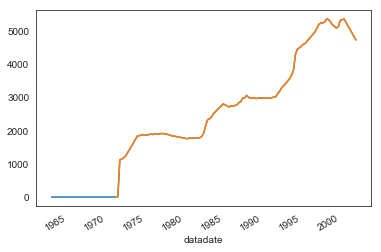

In [17]:
m1 = m[['gvkey','datadate','rdq']].dropna(axis = 0, how = 'any')
col = 'rdq'
icol = 'datadate'

target_data =  m1.loc[:,[icol, 'gvkey', col]]
target_data = target_data.drop_duplicates([icol, 'gvkey'], keep='first')
v1 = target_data.pivot(index=icol, columns='gvkey', values=col)
#v.count(0).plot()
import matplotlib.pyplot as plt
v.count(1).plot()
v1.count(1).plot()


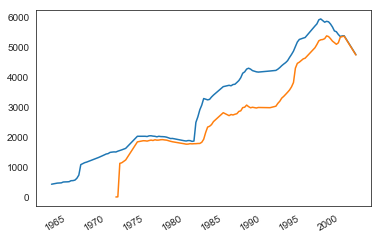

In [18]:
m['datadate'].value_counts().plot()
m1['datadate'].value_counts().plot()

In [19]:
m1['new_date'] = m1['datadate'].astype('str')

In [20]:
import datetime as dt
import time
from calendar import monthrange
#m1['new_date'] = dt.datetime.strptime(m1['new_date'], '%Y-%M-%D')
for i in m1.index:
    #m1.ix[i,'new_date'] = dt.datetime.strptime(m1.ix[i,'new_date'], '%Y-%m-%d')
    n += [dt.timedelta(days=monthrange(int(m1[i,'new_date'][:4]),int(m1[i,'new_date'][5:7]))[1]) for j in range(6)]
    m1.ix[i,'new_date'] = m1.ix[i,'new_date'].strftime('%Y-%m-%d')
m1['compare'] = m1['new_date'] > m1['rdq'].replace('/','-')

NameError: name 'n' is not defined

In [ ]:
n = 0
n += [dt.timedelta(days=monthrange(int(m1.ix[2,'new_date'][:4]),int(m1.ix[2,'new_date'][5:7]))[1]) for j in range(6)]

In [ ]:
m1.ix[2,'new_date'] = m1.ix[2,'new_date'] + dt.timedelta(days = monthrange(int(m1.ix[2,'new_date'][:4]),int(m1.ix[2,'new_date'][5:7]))[1])

In [ ]:
m = pd.DataFrame([1,2,3], [13,3,3])
print(m)

In [ ]:
v.dropna()

In [ ]:
v

In [ ]:
crsp = pd.read_csv('crsp returns all 1962-2001_csv.zip',
                   parse_dates=['date'])

In [ ]:
compustat = pd.read_csv('compustat_fundamentals qtr 1962-2001_csv.zip',
                          parse_dates=['datadate'])

In [29]:
compustat

NameError: name 'compustat' is not defined

In [28]:
a = pd.DataFrame([[1,2,3],[2,3,3],[3,4,2]])
print(a.corr())


          0         1         2
0  1.000000  1.000000 -0.866025
1  1.000000  1.000000 -0.866025
2 -0.866025 -0.866025  1.000000
